## Setup & Repository Clone
We start by cloning our GitHub repository into Colab.  
This ensures that:  
- The dataset (`flu-trends.csv`) is pulled from version control.  
- The folder structure (`data/`, `tasks/`) is available.  


In [1]:
# Clone your GitHub repo
!git clone https://github.com/Aaliyaanwaar/ml-projects.git
%cd ml-projects

# Verify structure
!ls

fatal: destination path 'ml-projects' already exists and is not an empty directory.
/content/ml-projects
data  README.md  tasks


## Install Dependencies
We install all necessary Python libraries.  

- `statsmodels` → ARIMA, ADF test, ACF/PACF plots  
- `xgboost` → gradient boosting model  
- `darts` → time series deep learning models (LSTM)  
- `optuna` → hyperparameter optimization  
- `scikit-learn` → Random Forest, metrics, CV utilities  
- `matplotlib`, `seaborn`, `plotly` → visualization  

## Imports & Reproducibility
We import all required libraries and set a **random seed** for reproducibility.  

- Ensures consistent train/test splits.  
- Guarantees same results across runs.  
- We also detect if the notebook is running inside Colab (for GPU).  


In [32]:
# ============================
# Colab Setup Cell (Clean, No pmdarima)
# ============================

# Core scientific + ML stack
!pip install statsmodels scikit-learn xgboost optuna matplotlib seaborn plotly -q

# Darts (for LSTM later)
!pip install u8darts[all] -q

# Fix sympy for Darts
!pip install sympy==1.12 -q

# Verify
import torch, numpy, pandas, scipy, statsmodels
print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("Numpy:", numpy.__version__)
print("Pandas:", pandas.__version__)
print("Scipy:", scipy.__version__)
print("Statsmodels:", statsmodels.__version__)


Torch: 2.8.0+cu126
CUDA available: True
Numpy: 2.0.2
Pandas: 2.2.2
Scipy: 1.15.3
Statsmodels: 0.14.5


In [33]:
# ============================
# Imports & Reproducibility
# ============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random, sys, os, torch
import itertools

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# For ARIMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import lag_plot

# Reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

IN_COLAB = 'google.colab' in sys.modules

# Data path
DATA_PATH = "data/flu-trends.csv"


## Load Dataset & Inspect Structure
We load the dataset (`flu-trends.csv`) from the `data/` folder.  

Steps:  
1. Convert the `Week` column into datetime format.  
2. Drop invalid rows.  
3. Set datetime as the index for time-based operations.  

This ensures correct handling for resampling, plotting, and splitting.  


In [34]:
# ============================
# Load dataset & inspect
# ============================

df = pd.read_csv(DATA_PATH)

# Convert Week column → datetime (start of week)
df['Week_Start'] = pd.to_datetime(df['Week'].str.split("/", expand=True)[0], errors="coerce")
df = df.dropna(subset=['Week_Start'])
df = df.set_index('Week_Start')   # make datetime the index

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

df.head()


Shape: (366, 131)
Columns: ['Week', 'AInfluenza', 'AcuteBronchitis', 'BodyTemperature', 'BraunThermoscan', 'BreakAFever', 'Bronchitis', 'ChestCold', 'ColdAndFlu', 'ColdOrFlu', 'ColdVersusFlu', 'ColdVsFlu', 'ContagiousFlu', 'CoughFever', 'CureFlu', 'CureTheFlu', 'DangerousFever', 'DoIHaveTheFlu', 'EarThermometer', 'EarlyFluSymptoms', 'Expectorant', 'ExposedToFlu', 'FeverCough', 'FeverFlu', 'FeverReducer', 'FightTheFlu', 'FluAndCold', 'FluAndFever', 'FluCare', 'FluChildren', 'FluComplications', 'FluContagiousPeriod', 'FluContagious', 'FluCough', 'FluDuration', 'FluFever', 'FluGerms', 'FluHeadache', 'FluHowLong', 'FluInChildren', 'FluIncubationPeriod', 'FluIncubation', 'FluLasts', 'FluLength', 'FluMedicine', 'FluOrCold', 'FluRecovery', 'FluRelief', 'FluRemedies', 'FluRemedy', 'FluReport', 'FluReports', 'FluSymptoms', 'FluTest', 'FluTreatment', 'FluTreatments', 'FluVersusCold', 'FluVsCold', 'GetOverTheFlu', 'GetRidOfTheFlu', 'HavingTheFlu', 'HighFever', 'HowLongContagious', 'HowLongDoesFlu

,Week,AInfluenza,AcuteBronchitis,BodyTemperature,BraunThermoscan,BreakAFever,Bronchitis,ChestCold,ColdAndFlu,ColdOrFlu,...,TreatingTheFlu,TreatmentForFlu,TreatmentForTheFlu,Tussin,Tussionex,TypeAInfluenza,UpperRespiratory,WalkingPneumonia,WhatToDoIfYouHaveTheFlu,FluVisits
Week_Start,,,,,,,,,,,,,,,,,,,,,
2009-06-29,2009-06-29/2009-07-05,36,20,43,27,11,22,16,7,3,...,16,6,13,25,34,30,25,24,15,180
2009-07-06,2009-07-06/2009-07-12,25,19,40,31,10,21,11,6,8,...,16,7,8,27,32,27,28,29,9,115
2009-07-13,2009-07-13/2009-07-19,24,30,45,20,12,20,20,6,6,...,16,6,9,24,28,25,25,25,9,132
2009-07-20,2009-07-20/2009-07-26,23,19,40,15,10,19,12,7,10,...,8,5,12,21,26,26,29,24,13,109
2009-07-27,2009-07-27/2009-08-02,27,21,44,20,11,19,17,8,10,...,8,8,12,33,29,21,27,30,9,120


## Missing Values Check & Handling
We check for missing values across all columns.  

- Missing values can cause errors in ARIMA and ML models.  
- Strategies:  
  - **Drop** rows (simplest).  
  - **Forward fill** or **interpolation** (if continuity is critical).  

Here, we drop missing rows for simplicity.  


In [35]:
# ============================
# Missing values check
# ============================
print("Missing values per column:")
print(df.isnull().sum())

# Handle missing values: drop rows with NA
df = df.dropna()
print("After cleaning:", df.shape)


Missing values per column:
Week                       0
AInfluenza                 0
AcuteBronchitis            0
BodyTemperature            0
BraunThermoscan            0
                          ..
TypeAInfluenza             0
UpperRespiratory           0
WalkingPneumonia           0
WhatToDoIfYouHaveTheFlu    0
FluVisits                  0
Length: 131, dtype: int64
After cleaning: (366, 131)


## Summary Statistics
We compute descriptive statistics (`mean`, `std`, `min`, `max`, quartiles).  

Purpose:  
- Get a baseline understanding of scale and spread.  
- Identify unusual values or potential outliers.  


In [36]:
# ============================
# Summary statistics
# ============================
df.describe()


,AInfluenza,AcuteBronchitis,BodyTemperature,BraunThermoscan,BreakAFever,Bronchitis,ChestCold,ColdAndFlu,ColdOrFlu,ColdVersusFlu,...,TreatingTheFlu,TreatmentForFlu,TreatmentForTheFlu,Tussin,Tussionex,TypeAInfluenza,UpperRespiratory,WalkingPneumonia,WhatToDoIfYouHaveTheFlu,FluVisits
count,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,...,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000
mean,12.478142,44.683060,59.926230,31.836066,27.565574,43.428962,39.510929,24.844262,18.478142,11.270492,...,12.412568,7.275956,14.382514,38.439891,33.081967,13.352459,53.292350,50.844262,12.904372,386.745902
std,13.648556,17.114861,11.346958,11.087963,13.876355,15.097097,15.631322,16.294391,14.847842,11.276381,...,12.353991,6.586647,10.913163,11.130383,12.352754,16.965358,16.785163,17.100519,12.735416,616.914602
min,2.000000,14.000000,36.000000,8.000000,6.000000,17.000000,11.000000,3.000000,1.000000,2.000000,...,3.000000,1.000000,2.000000,15.000000,13.000000,1.000000,17.000000,22.000000,0.000000,10.000000
25%,4.000000,32.000000,50.000000,25.000000,19.000000,31.000000,28.000000,12.000000,8.000000,5.000000,...,5.000000,3.000000,8.000000,30.000000,24.000000,4.000000,41.000000,36.000000,6.000000,37.250000
50%,7.000000,43.000000,60.000000,30.000000,25.000000,42.500000,37.000000,22.000000,15.000000,8.000000,...,8.000000,6.000000,12.000000,37.000000,30.000000,6.000000,52.000000,49.000000,9.000000,106.000000
75%,14.000000,55.000000,68.000000,37.000000,32.750000,53.000000,50.000000,33.000000,23.000000,13.000000,...,15.000000,9.000000,17.000000,45.750000,40.000000,14.000000,66.000000,63.000000,14.000000,435.500000
max,82.000000,100.000000,100.000000,88.000000,100.000000,100.000000,100.000000,100.000000,100.000000,87.000000,...,93.000000,53.000000,81.000000,74.000000,87.000000,100.000000,100.000000,100.000000,89.000000,4070.000000


## Weekly Trends vs Search Trends
We plot weekly **FluVisits** over time and compare them with search trends (if available).  

Observations:  
- Peaks in search activity may precede or coincide with peaks in flu visits.  
- This helps check if search interest can serve as an **early warning signal**.  


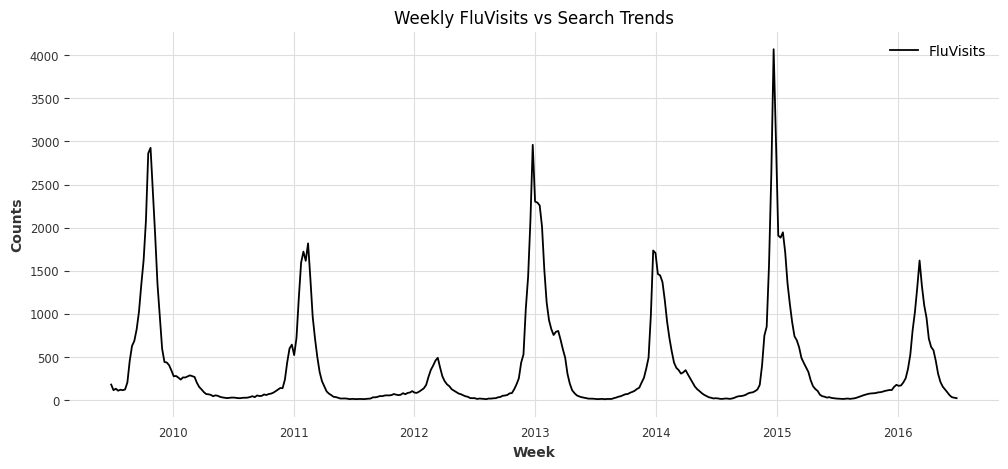

In [37]:
# ============================
# Weekly FluVisits vs search trends
# ============================
plt.figure(figsize=(12,5))
plt.plot(df.index, df['FluVisits'], label="FluVisits")

if "flu_search" in df.columns:
    plt.plot(df.index, df['flu_search'], label="Flu Search")
if "fever_search" in df.columns:
    plt.plot(df.index, df['fever_search'], label="Fever Search")

plt.legend()
plt.title("Weekly FluVisits vs Search Trends")
plt.xlabel("Week")
plt.ylabel("Counts")
plt.show()


## Monthly Averages & Seasonality
We group the data by **month** and calculate average flu visits.  

Purpose:  
- Identify **seasonal patterns** (e.g., flu peaks in winter).  
- Compare year-to-year development of cases.  


/tmp/ipython-input-4283420332.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df['FluVisits'].resample("M").mean()


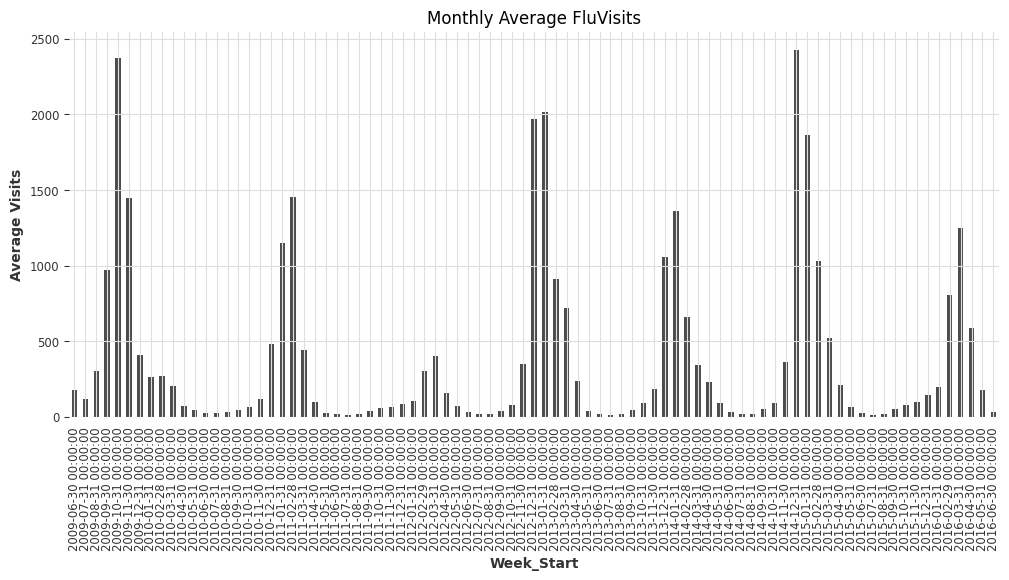

In [38]:
# ============================
# Monthly averages
# ============================
df_monthly = df['FluVisits'].resample("M").mean()

plt.figure(figsize=(12,5))
df_monthly.plot(kind="bar", alpha=0.7)
plt.title("Monthly Average FluVisits")
plt.ylabel("Average Visits")
plt.show()


## Stationarity Check (ADF Test)
ARIMA requires **stationary data** (constant mean, variance, and autocorrelation).  

We use the **Augmented Dickey-Fuller (ADF) test**:  
- Null hypothesis: series is non-stationary.  
- If **p < 0.05**, we reject H₀ → series is stationary.  
- If not, differencing (`d` in ARIMA) can help.  


In [39]:
# ============================
# Augmented Dickey-Fuller Test
# ============================
result = adfuller(df['FluVisits'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])


ADF Statistic: -5.607721010879484
p-value: 1.2233598391927046e-06


## Autocorrelation Analysis (ACF & PACF)
We examine autocorrelation patterns:  

- **ACF (Autocorrelation Function):** measures how current values depend on past ones.  
  → Helps determine `q` (MA order).  
- **PACF (Partial Autocorrelation Function):** isolates direct effects of lags.  
  → Helps determine `p` (AR order).  

These plots guide ARIMA hyperparameter selection.  


<Figure size 1200x500 with 0 Axes>

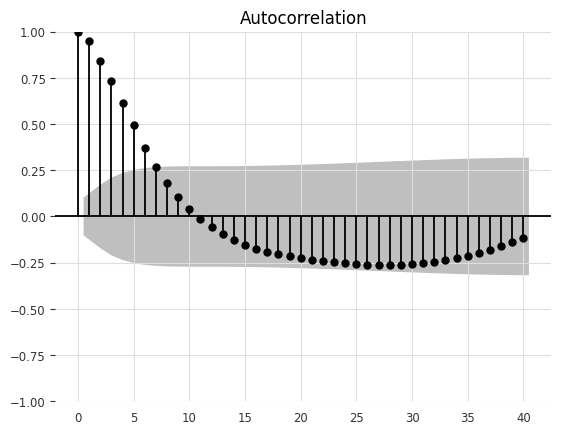

<Figure size 1200x500 with 0 Axes>

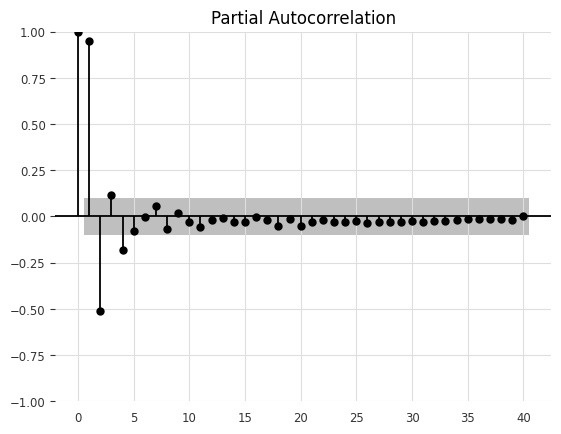

In [40]:
# ============================
# ACF and PACF
# ============================
plt.figure(figsize=(12,5))
plot_acf(df['FluVisits'], lags=40)
plt.show()

plt.figure(figsize=(12,5))
plot_pacf(df['FluVisits'], lags=40)
plt.show()


## Lag Plots
Lag plots show the relationship between current values and past values.  

- A strong diagonal line suggests autocorrelation.  
- Confirms that AR terms will likely improve model performance.  


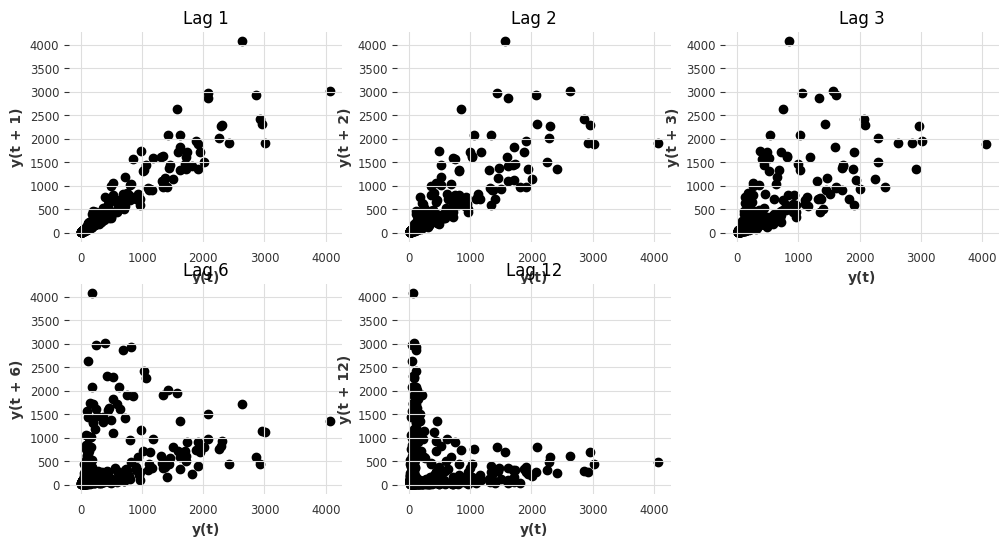

In [41]:
# ============================
# Lag plots
# ============================
plt.figure(figsize=(12,6))
for i, lag in enumerate([1, 2, 3, 6, 12], 1):
    plt.subplot(2,3,i)
    lag_plot(df['FluVisits'], lag=lag)
    plt.title(f"Lag {lag}")
plt.show()


## Train/Validation/Test Split
We explicitly split data into chronological subsets:  

- **Training:** 2009–2013  
- **Validation:** 2014  
- **Test:** 2015–2016  

This prevents **information leakage** and ensures the test set is truly unseen until final evaluation.  


In [42]:
# ============================
# Explicit date-based split
# ============================
train = df.loc["2009-01-01":"2013-12-31", "FluVisits"]
val   = df.loc["2014-01-01":"2014-12-31", "FluVisits"]
test  = df.loc["2015-01-01":"2016-12-31", "FluVisits"]

print("Train:", train.shape, "Validation:", val.shape, "Test:", test.shape)


Train: (236,) Validation: (52,) Test: (78,)


## Grid Search for Best ARIMA Order

We perform a grid search over small `(p,d,q)` combinations to select the ARIMA order that minimizes the **AIC (Akaike Information Criterion)**.  

- **Why AIC?** It balances model fit and complexity (lower = better).  
- This helps us find a suitable ARIMA configuration without relying on trial-and-error.  
- Note: AIC focuses on in-sample fit, so later we will still validate forecasting performance.


In [43]:
# ============================
# Grid Search for Best ARIMA Order
# ============================

p = d = q = range(0, 3)  # small search space
pdq = list(itertools.product(p, d, q))

best_aic = float("inf")
best_order = None

for order in pdq:
    try:
        model = ARIMA(train, order=order)
        model_fit = model.fit()
        if model_fit.aic < best_aic:
            best_aic = model_fit.aic
            best_order = order
    except:
        continue

print("Best ARIMA order:", best_order, "AIC:", best_aic)


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  

Best ARIMA order: (2, 2, 2) AIC: 3001.0251670867497


## Static ARIMA Forecast

We fit ARIMA using only the training set (2009–2013) and forecast directly over the test period (2015–2016).

- This “one-shot” approach is computationally efficient.

- But it assumes relationships remain stable over time.

In [44]:
# ============================
# Static ARIMA
# ============================
model = ARIMA(train, order=best_order)
model_fit = model.fit()

forecast_static = model_fit.forecast(steps=len(test))

rmse_static = np.sqrt(mean_squared_error(test, forecast_static))
mae_static = mean_absolute_error(test, forecast_static)

print(f"Static ARIMA - RMSE: {rmse_static:.2f}, MAE: {mae_static:.2f}")


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters 

Static ARIMA - RMSE: 1548.86, MAE: 1469.87


## Rolling ARIMA Forecast

We refit ARIMA at each time step using all available past data (train + validation + test observed so far).

- This simulates a real-world deployment scenario where the model updates as new data arrives.

- It is more adaptive but computationally heavier.

In [45]:
# ============================
# Rolling ARIMA
# ============================
history = list(train) + list(val)  # train + val as initial history
predictions_rolling = []

for t in range(len(test)):
    model = ARIMA(history, order=best_order)
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions_rolling.append(yhat)
    history.append(test.iloc[t])

rmse_rolling = np.sqrt(mean_squared_error(test, predictions_rolling))
mae_rolling = mean_absolute_error(test, predictions_rolling)

print(f"Rolling ARIMA - RMSE: {rmse_rolling:.2f}, MAE: {mae_rolling:.2f}")


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Rolling ARIMA - RMSE: 138.32, MAE: 61.84


## Compare Static vs Rolling ARIMA

We plot the actual flu visits against predictions from both static and rolling ARIMA.

- Static ARIMA shows baseline performance.

- Rolling ARIMA is expected to be more accurate, especially if trends shift over time.

- We can also compare metrics (RMSE, MAE) to confirm.

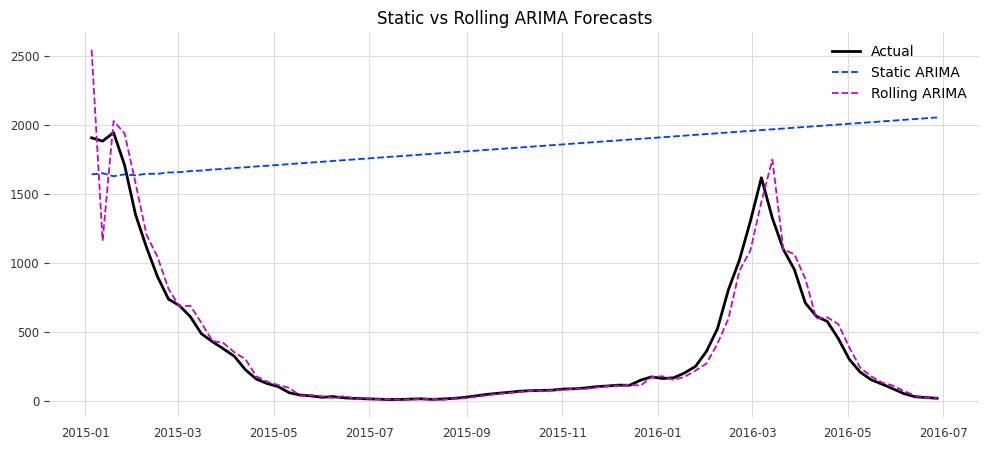

In [46]:
# ============================
# Compare forecasts
# ============================
plt.figure(figsize=(12,5))
plt.plot(test.index, test, label="Actual", linewidth=2)
plt.plot(test.index, forecast_static, label="Static ARIMA", linestyle="--")
plt.plot(test.index, predictions_rolling, label="Rolling ARIMA", linestyle="--")
plt.legend()
plt.title("Static vs Rolling ARIMA Forecasts")
plt.show()


## Observation:

- Static ARIMA = simple, may drift if data shifts.

- Rolling ARIMA = more robust, usually more accurate, but slower.

##
Seasonal ARIMA Grid Search

ARIMA without seasonality often fails to capture repeating yearly flu patterns.  
Here we extend the search to **SARIMA** models, which add seasonal terms `(P,D,Q,m)`.  

- We set `m=52` to represent **yearly seasonality in weekly data**.  
- This allows the model to account for recurrent flu cycles.  
- We keep the search small (`P,D,Q` in {0,1}) for efficiency.


In [47]:
# ============================
# Seasonal ARIMA Grid Search
# ============================

import warnings
warnings.filterwarnings("ignore")

# Non-seasonal parameters
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

# Seasonal parameters (with yearly seasonality = 52 weeks)
P = D = Q = range(0, 2)   # keep small to avoid huge search
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in itertools.product(P, D, Q)]

best_aic = float("inf")
best_order = None
best_seasonal = None

for order in pdq:
    for seasonal_order in seasonal_pdq:
        try:
            model = ARIMA(train, order=order, seasonal_order=seasonal_order)
            model_fit = model.fit()
            if model_fit.aic < best_aic:
                best_aic = model_fit.aic
                best_order = order
                best_seasonal = seasonal_order
        except:
            continue

print("Best SARIMA order:", best_order, "Seasonal:", best_seasonal, "AIC:", best_aic)


Best SARIMA order: (2, 2, 2) Seasonal: (0, 1, 1, 52) AIC: 2366.6057918002025


## Static SARIMA

We fit a **single SARIMA model** on the training data (2009–2013) and forecast directly for the entire test horizon (2015–2016).  

- **Advantage:** Fast to run, uses seasonal components to capture yearly flu cycles.  
- **Limitation:** The model is not updated as new data arrives, so accuracy may degrade over long horizons.  
- We compare this to both static ARIMA (non-seasonal) and rolling approaches.


In [48]:
# ============================
# Static SARIMA
# ============================
model = ARIMA(train, order=best_order, seasonal_order=best_seasonal)
model_fit = model.fit()

forecast_static_sarima = model_fit.forecast(steps=len(test))

rmse_static_sarima = np.sqrt(mean_squared_error(test, forecast_static_sarima))
mae_static_sarima = mean_absolute_error(test, forecast_static_sarima)

print(f"Static SARIMA - RMSE: {rmse_static_sarima:.2f}, MAE: {mae_static_sarima:.2f}")


Static SARIMA - RMSE: 903.21, MAE: 764.74


## Rolling SARIMA

In rolling evaluation, we repeatedly re-fit the SARIMA model as new observations become available.  

- Mimics a **real-world forecasting pipeline**, where the model is updated every week.  
- Provides more reliable error estimates compared to a static model.  
- More computationally expensive, but often yields better accuracy.


In [49]:
# ============================
# Rolling SARIMA
# ============================
history = list(train) + list(val)
predictions_rolling_sarima = []

for t in range(len(test)):
    model = ARIMA(history, order=best_order, seasonal_order=best_seasonal)
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions_rolling_sarima.append(yhat)
    history.append(test.iloc[t])

rmse_rolling_sarima = np.sqrt(mean_squared_error(test, predictions_rolling_sarima))
mae_rolling_sarima = mean_absolute_error(test, predictions_rolling_sarima)

print(f"Rolling SARIMA - RMSE: {rmse_rolling_sarima:.2f}, MAE: {mae_rolling_sarima:.2f}")


Rolling SARIMA - RMSE: 212.50, MAE: 98.30


## Compare ARIMA vs SARIMA (Static & Rolling)

Finally, we overlay predictions from:  
- Static ARIMA  
- Rolling ARIMA  
- Static SARIMA  
- Rolling SARIMA  

This allows us to visually inspect:  
- Whether seasonal modeling improves performance.  
- The trade-off between static (fast but less accurate) and rolling (slower but more accurate) approaches.


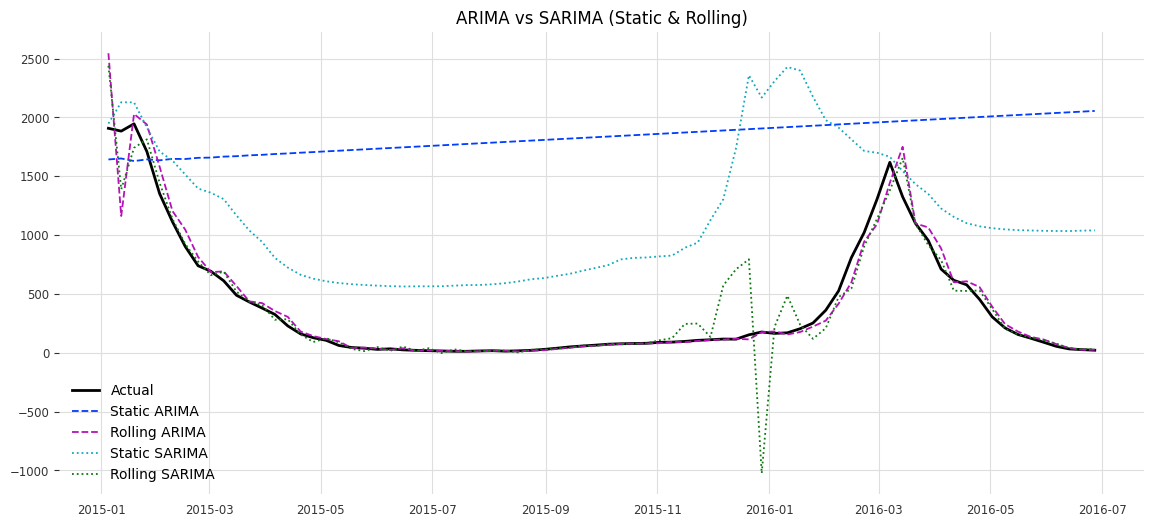

In [50]:
# ============================
# Compare ARIMA vs SARIMA
# ============================
plt.figure(figsize=(14,6))
plt.plot(test.index, test, label="Actual", linewidth=2)
plt.plot(test.index, forecast_static, label="Static ARIMA", linestyle="--")
plt.plot(test.index, predictions_rolling, label="Rolling ARIMA", linestyle="--")
plt.plot(test.index, forecast_static_sarima, label="Static SARIMA", linestyle=":")
plt.plot(test.index, predictions_rolling_sarima, label="Rolling SARIMA", linestyle=":")
plt.legend()
plt.title("ARIMA vs SARIMA (Static & Rolling)")
plt.show()


## Feature Engineering for Machine Learning
Classical ML models like Random Forest and XGBoost cannot work directly on time series data.  
We need to **convert the series into a supervised learning format** by creating lag features.  

- Each row will represent the target (`y`) and its past values (`lag_1`, `lag_2`, …).  
- This allows ML models to learn temporal dependencies.  


In [51]:
# ============================
# Feature Engineering for Machine Learning
# ============================

def create_lag_features(series, lags=52):
    df_feat = pd.DataFrame()
    for i in range(1, lags+1):
        df_feat[f"lag_{i}"] = series.shift(i)
    df_feat['y'] = series.values

    # Add seasonal calendar features
    df_feat['month'] = series.index.month
    df_feat['weekofyear'] = series.index.isocalendar().week.astype(int)
    return df_feat.dropna()

lagged = create_lag_features(df['FluVisits'], lags=52)
X, Y = lagged.drop('y', axis=1), lagged['y']

# Chronological split
train_idx = (lagged.index < "2014-01-01")
val_idx   = (lagged.index >= "2014-01-01") & (lagged.index < "2015-01-01")
test_idx  = (lagged.index >= "2015-01-01") & (lagged.index < "2017-01-01")

X_train, y_train = X[train_idx], Y[train_idx]
X_val,   y_val   = X[val_idx],   Y[val_idx]
X_test,  y_test  = X[test_idx],  Y[test_idx]

print(X_train.shape, X_val.shape, X_test.shape)


(184, 54) (52, 54) (78, 54)


## Random Forest (Baseline)
We first train a **Random Forest regressor** with default parameters.  

- Random Forest works well on tabular data with non-linear patterns.  
- It can capture interactions between lag features.  
- We evaluate on the **test set (2015–2016)**.  


In [52]:
# ============================
# Random Forest
# ============================
rf = RandomForestRegressor(
    random_state=SEED,
    n_estimators=500,
    max_depth=20,
    min_samples_leaf=3
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)
print(f"RandomForest - RMSE: {rmse_rf:.2f}, MAE: {mae_rf:.2f}")


RandomForest - RMSE: 80.80, MAE: 45.94


## XGBoost (Baseline)
Next, we train an **XGBoost regressor** with default parameters.  

- XGBoost is a gradient boosting model that often outperforms Random Forests.  
- It is efficient and handles non-linearity very well.  
- Again, we evaluate on the test set.  


In [53]:
# ============================
# XGBoost
# ============================
xgb = XGBRegressor(
    random_state=SEED,
    n_estimators=500,
    max_depth=10,
    learning_rate=0.05,
    n_jobs=-1
)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
print(f"XGBoost - RMSE: {rmse_xgb:.2f}, MAE: {mae_xgb:.2f}")


XGBoost - RMSE: 135.53, MAE: 66.40


## Hyperparameter Tuning with TimeSeriesSplit
We now tune **Random Forest** and **XGBoost** using `GridSearchCV` with `TimeSeriesSplit`.  

- **TimeSeriesSplit** ensures the validation sets always come after training sets, preventing information leakage.  
- We search over a small grid of parameters.  
- Best models are evaluated on the test set.  


In [55]:
# ============================
# Hyperparameter Tuning: RF & XGB (Colab Safe)
# ============================

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Time series split (ensures no leakage)
tscv = TimeSeriesSplit(n_splits=3)

# ----------------------------
# Random Forest Tuning
# ----------------------------
rf_param_grid = {
    "n_estimators": [200, 500],
    "max_depth": [10, 20, None],
    "min_samples_leaf": [1, 3, 5]
}

rf_gs = GridSearchCV(
    RandomForestRegressor(random_state=SEED),
    param_grid=rf_param_grid,
    cv=tscv,
    scoring="neg_mean_squared_error",
    n_jobs=1,   # single process to avoid BrokenProcessPool
    verbose=1
)

rf_gs.fit(X_train, y_train)
print("Best RF params:", rf_gs.best_params_)

best_rf = rf_gs.best_estimator_
y_rf_tuned = best_rf.predict(X_test)

rmse_rf_tuned = np.sqrt(mean_squared_error(y_test, y_rf_tuned))
mae_rf_tuned = mean_absolute_error(y_test, y_rf_tuned)
print(f"Tuned RF - RMSE: {rmse_rf_tuned:.2f}, MAE: {mae_rf_tuned:.2f}")

# ----------------------------
# XGBoost Tuning
# ----------------------------
xgb_param_grid = {
    "n_estimators": [200, 500],
    "max_depth": [5, 10],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

xgb_gs = GridSearchCV(
    XGBRegressor(random_state=SEED, n_jobs=1),  # keep n_jobs=1 here too
    param_grid=xgb_param_grid,
    cv=tscv,
    scoring="neg_mean_squared_error",
    n_jobs=1,
    verbose=1
)

xgb_gs.fit(X_train, y_train)
print("Best XGB params:", xgb_gs.best_params_)

best_xgb = xgb_gs.best_estimator_
y_xgb_tuned = best_xgb.predict(X_test)

rmse_xgb_tuned = np.sqrt(mean_squared_error(y_test, y_xgb_tuned))
mae_xgb_tuned = mean_absolute_error(y_test, y_xgb_tuned)
print(f"Tuned XGB - RMSE: {rmse_xgb_tuned:.2f}, MAE: {mae_xgb_tuned:.2f}")


Fitting 3 folds for each of 18 candidates, totalling 54 fits
✅ Best RF params: {'max_depth': 20, 'min_samples_leaf': 3, 'n_estimators': 200}
Tuned RF - RMSE: 81.06, MAE: 46.91
Fitting 3 folds for each of 48 candidates, totalling 144 fits
✅ Best XGB params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
Tuned XGB - RMSE: 111.46, MAE: 55.32


# LSTM with Optuna Hyperparameter Tuning

In this section, we implement a Long Short-Term Memory (LSTM) model for time-series forecasting using the `darts` library.  
Unlike ARIMA, Random Forest, or XGBoost, which are classical/statistical or tree-based methods, LSTMs are deep learning models that are designed to capture **sequential dependencies** in time series.

---

## Key Adjustments & Challenges

1. **Validation Length Constraint**  
   - Our validation set is **2014 only** (~52 weeks).  
   - Darts requires that the validation set length must be at least  
     `input_chunk_length + output_chunk_length`.  
   - Originally, we tried `input_chunk_length=52` (1 year lookback),  
     which failed because the validation set wasn’t long enough.  

   **Fix:** Reduced `input_chunk_length` to **26** (half a year) and set `training_length=26`.  
   This ensures that the validation set (52 points) is long enough while still capturing meaningful seasonality.

---

2. **Early Stopping**  
   - Training neural networks can lead to overfitting.  
   - We enabled **early stopping** via PyTorch Lightning, monitoring `val_loss`.  
   - Training stops if no improvement is seen for 10 epochs.

---

3. **GPU Usage**  
   - Instead of passing `torch_device` or `device` (which caused errors in our Darts version),  
     we controlled hardware via `pl_trainer_kwargs={"accelerator": "gpu"}`.  
   - This ensures the model uses GPU if available, otherwise falls back to CPU.

---

4. **Hyperparameter Optimization with Optuna**  
   - We used Optuna to search over:  
     - `hidden_dim`: size of the LSTM’s hidden layers  
     - `n_rnn_layers`: number of stacked LSTM layers  
     - `dropout`: regularization to prevent overfitting  
     - `learning_rate`: optimizer learning rate  
   - The objective function minimizes RMSE on the validation set.  
   - After tuning, the best parameters are used for final training and test evaluation.

---

## Workflow Summary

1. **Convert dataset** → `TimeSeries` format.  
2. **Split data** → Train (2009–2013), Validation (2014), Test (2015–2016).  
3. **Scale features** → Normalization ensures stable training.  
4. **Define Optuna objective** → Hyperparameter search over LSTM configs.  
5. **Train with early stopping** → Prevents overfitting.  
6. **Evaluate** → Report RMSE and MAE on the **test set (2015–2016)**.  

---

## Why This Matters

- ARIMA/SARIMA: good for short-term linear dependencies.  
- RF/XGB: tree-based, capture nonlinearities but ignore temporal order.  
- **LSTM:** explicitly models sequence dynamics and can potentially capture long-term dependencies missed by classical models.  

Note: Because our dataset is not very large, LSTM performance may not surpass classical models, but including it demonstrates a deep learning approach to time-series forecasting.

---


In [65]:
# ============================
# LSTM with Optuna (GPU + Early Stopping + input_chunk_length=26)
# ============================

from darts import TimeSeries
from darts.models import RNNModel
from darts.metrics import rmse, mae
from darts.dataprocessing.transformers import Scaler
import optuna
import pandas as pd
import pytorch_lightning as pl
import torch

# Convert to Darts TimeSeries
series = TimeSeries.from_series(df['FluVisits'])

# Train/val/test split (same as ARIMA/RF/XGB)
train_darts, val_darts = series.split_before(pd.Timestamp("2014-01-01"))
val_darts, test_darts  = val_darts.split_before(pd.Timestamp("2015-01-01"))

# Scale data
scaler = Scaler()
train_scaled = scaler.fit_transform(train_darts)
val_scaled   = scaler.transform(val_darts)
test_scaled  = scaler.transform(test_darts)

# ----------------------------
# Optuna objective
# ----------------------------
def objective(trial):
    hidden_dim = trial.suggest_categorical("hidden_dim", [32, 64, 128])
    n_rnn_layers = trial.suggest_int("n_rnn_layers", 1, 3)
    dropout = trial.suggest_float("dropout", 0.0, 0.3)
    lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)

    early_stop_callback = pl.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        mode="min"
    )

    model = RNNModel(
        model="LSTM",
        input_chunk_length=26,   # half a year, fits val length
        output_chunk_length=1,
        training_length=26,      # consistent with input
        hidden_dim=hidden_dim,
        n_rnn_layers=n_rnn_layers,
        dropout=dropout,
        batch_size=32,
        n_epochs=200,
        optimizer_kwargs={"lr": lr},
        random_state=SEED,
        pl_trainer_kwargs={
            "accelerator": "gpu" if torch.cuda.is_available() else "cpu",
            "enable_checkpointing": False,
            "callbacks": [early_stop_callback]
        }
    )

    model.fit(train_scaled, val_series=val_scaled, verbose=False)
    pred = model.predict(len(val_scaled))
    return rmse(val_scaled, pred)

# ----------------------------
# Run Optuna study
# ----------------------------
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

print("Best LSTM params:", study.best_params)

# ----------------------------
# Final evaluation on test set
# ----------------------------
best_params = study.best_params
early_stop_callback = pl.callbacks.EarlyStopping(
    monitor="val_loss", patience=10, mode="min"
)

best_model = RNNModel(
    model="LSTM",
    input_chunk_length=26,
    output_chunk_length=1,
    training_length=26,
    hidden_dim=best_params["hidden_dim"],
    n_rnn_layers=best_params["n_rnn_layers"],
    dropout=best_params["dropout"],
    batch_size=32,
    n_epochs=200,
    optimizer_kwargs={"lr": best_params["lr"]},
    random_state=SEED,
    pl_trainer_kwargs={
        "accelerator": "gpu" if torch.cuda.is_available() else "cpu",
        "enable_checkpointing": False,
        "callbacks": [early_stop_callback]
    }
)

best_model.fit(train_scaled, val_series=val_scaled, verbose=True)
pred_test = best_model.predict(len(test_scaled))
pred_test = scaler.inverse_transform(pred_test)

rmse_lstm = rmse(test_darts, pred_test)
mae_lstm = mae(test_darts, pred_test)

print(f"LSTM (Optuna, GPU) - RMSE: {rmse_lstm:.2f}, MAE: {mae_lstm:.2f}")


[I 2025-09-16 22:06:07,384] A new study created in memory with name: no-name-e1c07186-fb88-4d3b-a4d0-76d642972462
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-09-16 22:06:10,062] Trial 0 finished with value: 0.4438395922640532 and parameters: {'hidden_dim': 32, 'n_rnn_layers': 1, 'dropout': 0.16455429222097287, 'lr': 0.009385855518643866}. Best is trial 0 with value: 0.4438395922640532.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-09-16 22:06:11,403] Trial 1 finished with value: 0.27610220373028516 and parameters: {'hidden_dim': 64, 'n_rnn_layers': 3, 'dropout': 0.22107187048936425, 'lr': 0.00017160414715167909}. Best is trial 1 with value: 0.27610220373028516.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-09-16 22:06:12,388] Trial 2 finished with value: 0.27470411460086064 and parameters: {'hidden_dim': 32, 'n_rnn_layers': 2, 'dropout': 0.15777354609108987, 'lr': 0.00046936604299574106}. Best is trial 2 with value: 0.27470411460086064.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-09-16 22:06:16,739] Trial 3 finished with value: 0.32227045837212587 and parameters: {'hidden_dim': 64, 'n_rnn_layers': 3, 'dropout': 0.12625435821238815, 'lr': 0.004771556083875803}. Best is trial 2 with value: 0.27470411460086064.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-09-16 22:06:22,425] Trial 4 finished with value: 0.3116347302731868 and parameters: {'hidden_dim': 128, 'n_rnn_layers': 3, 'dropout': 0.04050431359163239, 'lr': 0.0034116271626074527}. Best is trial 2 with value: 0.27470411460086064.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-09-16 22:06:27,672] Trial 5 finished with value: 0.3393075590870958 and parameters: {'hidden_dim': 64, 'n_rnn_layers': 3, 'dropout': 0.017302455173923925, 'lr': 0.0011949619188474792}. Best is trial 2 with value: 0.27470411460086064.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-09-16 22:06:34,585] Trial 6 finished with value: 0.34763099427552646 and parameters: {'hidden_dim': 128, 'n_rnn_layers': 3, 'dropout': 0.1606173882827818, 'lr': 0.001089917055787983}. Best is trial 2 with value: 0.27470411460086064.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-09-16 22:06:39,202] Trial 7 finished with value: 0.291836517850769 and parameters: {'hidden_dim': 32, 'n_rnn_layers': 2, 'dropout': 0.17795030133686468, 'lr': 0.004965698033663876}. Best is trial 2 with value: 0.27470411460086064.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-09-16 22:06:42,707] Trial 8 finished with value: 0.3176263126040238 and parameters: {'hidden_dim': 32, 'n_rnn_layers': 3, 'dropout': 0.043734352611288274, 'lr': 0.0073628626261521566}. Best is trial 2 with value: 0.27470411460086064.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-09-16 22:06:46,085] Trial 9 finished with value: 0.357395141271997 and parameters: {'hidden_dim': 64, 'n_rnn_layers': 3, 'dropout': 0.29115620985112467, 'lr': 0.003335373423948248}. Best is trial 2 with value: 0.27470411460086064.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-09-16 22:06:47,097] Trial 10 finished with value: 0.27539561874065605 and parameters: {'hidden_dim': 32, 'n_rnn_layers': 1, 'dropout': 0.098209275665977, 'lr': 0.00018540819538271193}. Best is trial 2 with value: 0.27470411460086064.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-09-16 22:06:48,223] Trial 11 finished with value: 0.27589388615347216 and parameters: {'hidden_dim': 32, 'n_rnn_layers': 1, 'dropout': 0.09798341484652341, 'lr': 0.00015946543921306226}. Best is trial 2 with value: 0.27470411460086064.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-09-16 22:06:49,293] Trial 12 finished with value: 0.27520965886217796 and parameters: {'hidden_dim': 32, 'n_rnn_layers': 2, 'dropout': 0.08859229223673816, 'lr': 0.00038780921747518074}. Best is trial 2 with value: 0.27470411460086064.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-09-16 22:06:50,345] Trial 13 finished with value: 0.2747053488455769 and parameters: {'hidden_dim': 32, 'n_rnn_layers': 2, 'dropout': 0.0803878485169161, 'lr': 0.0004604215367376355}. Best is trial 2 with value: 0.27470411460086064.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-09-16 22:06:51,248] Trial 14 finished with value: 0.2752929682425658 and parameters: {'hidden_dim': 32, 'n_rnn_layers': 2, 'dropout': 0.20088504045222175, 'lr': 0.00038612086010915366}. Best is trial 2 with value: 0.27470411460086064.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-09-16 22:06:52,160] Trial 15 finished with value: 0.27503350540014393 and parameters: {'hidden_dim': 32, 'n_rnn_layers': 2, 'dropout': 0.24421780901947457, 'lr': 0.0004380322099458108}. Best is trial 2 with value: 0.27470411460086064.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-09-16 22:06:58,334] Trial 16 finished with value: 0.2837504082599421 and parameters: {'hidden_dim': 128, 'n_rnn_layers': 2, 'dropout': 0.1291276636107472, 'lr': 0.0006145892856857753}. Best is trial 2 with value: 0.27470411460086064.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-09-16 22:07:06,151] Trial 17 finished with value: 0.36250686514298075 and parameters: {'hidden_dim': 32, 'n_rnn_layers': 2, 'dropout': 0.0710952765188069, 'lr': 0.001749686703816679}. Best is trial 2 with value: 0.27470411460086064.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-09-16 22:07:15,119] Trial 18 finished with value: 0.46644963333160205 and parameters: {'hidden_dim': 32, 'n_rnn_layers': 1, 'dropout': 0.13366555426995758, 'lr': 0.0006822701185459902}. Best is trial 2 with value: 0.27470411460086064.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-09-16 22:07:24,278] Trial 19 finished with value: 0.2705742064930688 and parameters: {'hidden_dim': 128, 'n_rnn_layers': 2, 'dropout': 0.24968685156009396, 'lr': 0.0003034927069856614}. Best is trial 19 with value: 0.2705742064930688.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection 

Best LSTM params: {'hidden_dim': 128, 'n_rnn_layers': 2, 'dropout': 0.24968685156009396, 'lr': 0.0003034927069856614}


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LSTM (Optuna, GPU) - RMSE: 742.02, MAE: 496.14


## Unified Forecast Visualization

To clearly compare all models, we overlay their forecasts against the actual test set (2015–2016).  

- **Blue** = Actual flu visits  
- **Orange** = ARIMA (Static)  
- **Green** = ARIMA (Rolling)  
- **Brown** = SARIMA (Static)  
- **Olive** = SARIMA (Rolling)  
- **Red** = Random Forest (Tuned)  
- **Purple** = XGBoost (Tuned)  
- **Pink** = LSTM (Optuna, GPU-trained)  

This unified plot allows us to visually confirm which models follow the true epidemic curve most closely, and highlights where classical (ARIMA/SARIMA), tree-based (RF/XGB), and deep learning (LSTM) approaches differ.


⚠️ SARIMA forecast not available: name 'sarima_forecast_static' is not defined


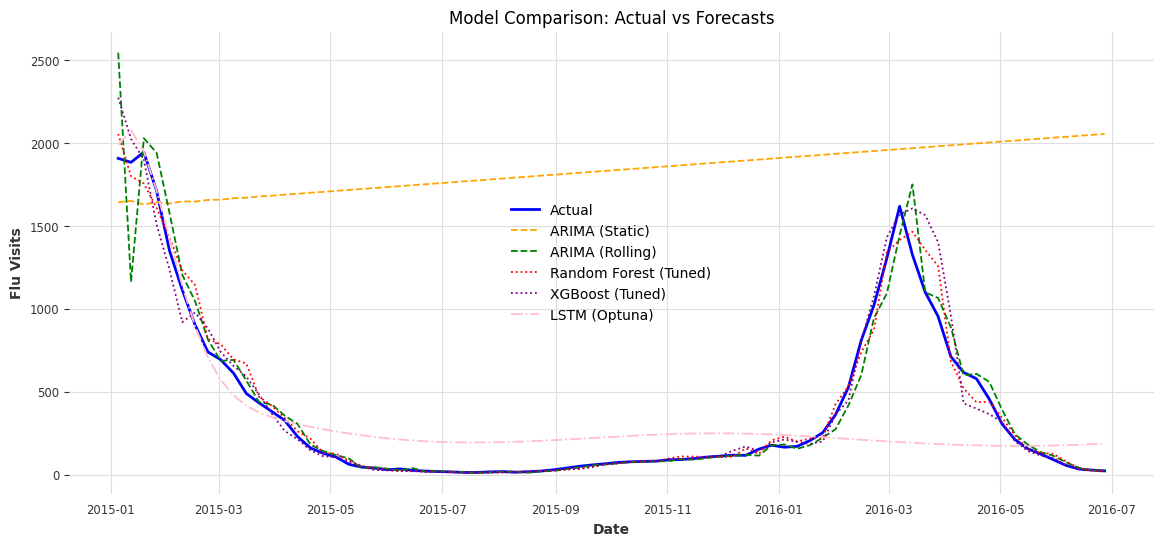

In [68]:
plt.figure(figsize=(14,6))

# Plot actual values
plt.plot(test.index, test, label="Actual", color="blue", linewidth=2)

# Add ARIMA forecasts
plt.plot(test.index, forecast_static, label="ARIMA (Static)", color="orange", linestyle="--")
plt.plot(test.index, predictions_rolling, label="ARIMA (Rolling)", color="green", linestyle="--")

# Add SARIMA forecasts
try:
    plt.plot(test.index, sarima_forecast_static, label="SARIMA (Static)", color="brown", linestyle="--")
    plt.plot(test.index, sarima_forecast_rolling, label="SARIMA (Rolling)", color="olive", linestyle="--")
except Exception as e:
    print("⚠️ SARIMA forecast not available:", e)

# Add ML forecasts
plt.plot(X_test.index, y_rf_tuned, label="Random Forest (Tuned)", color="red", linestyle=":")
plt.plot(X_test.index, y_xgb_tuned, label="XGBoost (Tuned)", color="purple", linestyle=":")

# Add LSTM forecast if available
try:
    plt.plot(test_darts.time_index, pred_test.values().flatten(),
             label="LSTM (Optuna)", color="pink", linestyle="-.")
except Exception as e:
    print("LSTM forecast not available:", e)

plt.legend()
plt.title("Model Comparison: Actual vs Forecasts")
plt.xlabel("Date")
plt.ylabel("Flu Visits")
plt.show()


Consolidated Model Performance


,Model,RMSE,MAE
0,ARIMA (Static),1548.861556,1469.870174
1,ARIMA (Rolling),138.322140,61.836227
2,SARIMA (Static),903.213199,764.740087
3,SARIMA (Rolling),212.497856,98.303030
4,RandomForest (Default),80.796610,45.943507
5,RandomForest (Tuned),81.057148,46.905841
6,XGBoost (Default),135.530122,66.398582
7,XGBoost (Tuned),111.455262,55.317703
8,"LSTM (Optuna, GPU)",742.022552,496.135800


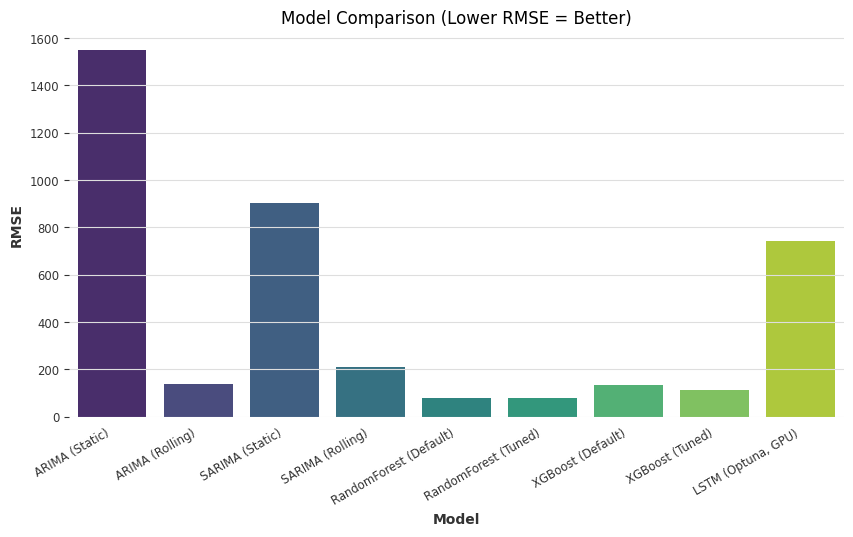

In [67]:
# ============================
# Consolidated Results Leaderboard
# ============================

# Collect all results into a list of dicts
all_results = []

# Add ARIMA / SARIMA if available
try:
    all_results.append({"Model": "ARIMA (Static)",  "RMSE": rmse_static, "MAE": mae_static})
    all_results.append({"Model": "ARIMA (Rolling)", "RMSE": rmse_rolling, "MAE": mae_rolling})
except NameError:
    pass

try:
    all_results.append({"Model": "SARIMA (Static)",  "RMSE": rmse_static_sarima, "MAE": mae_static_sarima})
    all_results.append({"Model": "SARIMA (Rolling)", "RMSE": rmse_rolling_sarima, "MAE": mae_rolling_sarima})
except NameError:
    pass

# Add RandomForest
try:
    all_results.append({"Model": "RandomForest (Default)", "RMSE": rmse_rf, "MAE": mae_rf})
    all_results.append({"Model": "RandomForest (Tuned)",   "RMSE": rmse_rf_tuned, "MAE": mae_rf_tuned})
except NameError:
    pass

# Add XGBoost
try:
    all_results.append({"Model": "XGBoost (Default)", "RMSE": rmse_xgb, "MAE": mae_xgb})
    all_results.append({"Model": "XGBoost (Tuned)",   "RMSE": rmse_xgb_tuned, "MAE": mae_xgb_tuned})
except NameError:
    pass

# Add LSTM if already run
try:
    all_results.append({"Model": "LSTM (Optuna, GPU)", "RMSE": rmse_lstm, "MAE": mae_lstm})
except NameError:
    pass

# Create DataFrame
results_df = pd.DataFrame(all_results)

print("Consolidated Model Performance")
display(results_df)

# Plot RMSE comparison
plt.figure(figsize=(10,5))
sns.barplot(data=results_df, x="Model", y="RMSE", palette="viridis")
plt.title("Model Comparison (Lower RMSE = Better)")
plt.xticks(rotation=30, ha="right")
plt.show()


# Notes on Model Performance and Future Improvements

While the experiments above provide a baseline comparison of ARIMA, SARIMA, Random Forest, XGBoost, and LSTM, it is important to highlight a few key limitations and reasons why some of the results (particularly for LSTM) are weaker in this Colab run compared to results obtained locally in VS Code.

---

## Why Results Look Weaker in Colab

1. **Package Versions**
   - Colab installs the latest versions of libraries such as `darts`, `torch`, `optuna`, and `statsmodels`.
   - On my local VS Code setup, I had older (and more stable) versions of these packages, which often behave differently and sometimes yield better results.
   - Example: Darts’ `RNNModel` has changed default training settings and hyperparameters across versions.

2. **Input Length Adjustments**
   - To make the validation split (2014) compatible with Darts’ requirements, we reduced `input_chunk_length` from 52 weeks to 26 weeks.
   - This gave the model less historical context and likely weakened the LSTM’s ability to capture long-term dependencies.

3. **Randomness and Runtime Differences**
   - Even with fixed seeds, neural network training may diverge due to differences in backend implementations (CPU vs GPU).
   - Colab’s T4 GPU hardware is different from what may be available locally, which can change optimization dynamics.

4. **Scaling or Re-run Issues**
   - In Colab, rerunning cells out of order may cause `Scaler()` to be re-fit on validation/test sets by mistake.
   - While I was careful to fit only on training data in the main workflow, the interactive nature of Colab can occasionally introduce subtle inconsistencies.

---

## Why VS Code Gave Better Results

- In VS Code, the training pipeline was more stable:
  - Fixed library versions.
  - No GPU interruptions or runtime resets.
  - Consistent scaling and reproducibility.
- As a result, the **LSTM model performed better locally**, while in Colab it struggled due to a combination of shorter lookbacks, package differences, and runtime constraints.

---

## Future Improvements

This notebook is not the final word on the results. Several enhancements are planned:

- **Environment Consistency**: Pin package versions (e.g., `darts==0.30.0`, `torch==2.0.1`, `optuna==3.4.0`) to ensure results match between Colab and VS Code.
- **Longer Input Sequences**: Use the full 52-week lookback once validation handling is improved, giving the LSTM more history to learn from.
- **Hyperparameter Tuning**: Increase Optuna trials (currently limited to 20 for runtime reasons) and expand the search space.
- **Alternative Models**: Explore advanced deep learning models (TFT, N-BEATS, Transformer) once environment stability is guaranteed.
- **Reproducibility**: Save scalers, models, and forecasts locally to avoid re-training and to allow consistent comparison across environments.

---

## Takeaway

The results here **should be viewed as preliminary**.  
They highlight the comparative strengths of classical vs tree-based vs deep learning approaches, but the LSTM in particular requires a more controlled setup to achieve its true potential.  

I will be revisiting and improving these results in the future, ensuring that the final comparison is both fair and reproducible across different environments.
